In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import sklearn as skl
import tensorflow as tf
import pandas as pd

In [3]:
df = pd.read_csv("../Resources/cleaned_drug_data.csv")
df.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,...,Legalh,LSD,Meth,Mushrooms,Nicotine,VSA,illegal_score_sum,legal_score_sum,illegal_use,legal_use
0,2,25-34,M,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,...,0,0,1,0,1,0,3,4,1,1
1,3,35-44,M,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,...,0,0,0,0,0,0,0,3,0,1
2,4,18-24,F,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,...,0,0,0,0,0,0,1,3,1,1
3,5,35-44,F,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,...,0,0,0,0,0,0,0,3,0,1
4,6,65+,F,Left school at 18 years,Canada,White,-0.67825,-0.30033,-1.55521,2.03972,...,0,0,0,0,1,0,0,3,0,1


In [4]:
df = df.drop(columns= ['VSA', 'Nicotine','Mushrooms','Meth','LSD','Legalh','Ketamine','Heroin','Ecstasy','Crack','Coke','Choc','Cannabis','Caff','illegal_score_sum','legal_score_sum','legal_use','Amyl','Amphet','Alcohol', 'ID','Benzos'])
df

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,illegal_use
0,25-34,M,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1
1,35-44,M,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,0
2,18-24,F,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1
3,35-44,F,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,0
4,65+,F,Left school at 18 years,Canada,White,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,18-24,F,"Some college or university, no certificate or ...",USA,White,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,1
1872,18-24,M,"Some college or university, no certificate or ...",USA,White,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,1
1873,25-34,F,University degree,USA,White,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,1
1874,18-24,F,"Some college or university, no certificate or ...",USA,White,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,1


In [5]:
numerical_data = pd.get_dummies(df)
numerical_data

,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,illegal_use,Age_18-24,Age_25-34,...,Country_Republic of Ireland,Country_UK,Country_USA,Ethnicity_Asian,Ethnicity_Black,Ethnicity_Mixed-Black/Asian,Ethnicity_Mixed-White/Asian,Ethnicity_Mixed-White/Black,Ethnicity_Other,Ethnicity_White
0,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,1,0,1,...,0,1,0,0,0,0,0,0,0,1
1,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,1,1,0,...,0,1,0,0,0,0,0,0,0,1
3,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,-1.19430,1.74091,1.88511,0.76096,-1.13788,0.88113,1.92173,1,1,0,...,0,0,1,0,0,0,0,0,0,1
1872,-0.24649,1.74091,0.58331,0.76096,-1.51840,0.88113,0.76540,1,1,0,...,0,0,1,0,0,0,0,0,0,1
1873,1.13281,-1.37639,-1.27553,-1.77200,-1.38502,0.52975,-0.52593,1,0,1,...,0,0,1,0,0,0,0,0,0,1
1874,0.91093,-1.92173,0.29338,-1.62090,-2.57309,1.29221,1.22470,1,1,0,...,0,0,1,0,0,0,0,0,0,1


In [6]:
X = numerical_data.drop(columns=["illegal_use"])
Y = numerical_data["illegal_use"]

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

In [8]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler() model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)

In [9]:
# Transform the training and testing data by using the X_scaler and y_scaler models

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [10]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    
    # Instantiate a Sequential model
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers.
    activation = hp.Choice('activation', ['relu','tanh','sigmoid'])
    
    # Allow kerastuner to decide the number of neurons in first layer and also
    # the activation function. 
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=150,
        step=2), activation=activation, input_dim=38))

    # Allow kerastuner to decide the number of hidden layers and number of 
    # neurons in each one
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))
    
    # Define the output layer
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model  

In [11]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

In [12]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled, Y_train,epochs=50, validation_data=(X_test_scaled,Y_test))

Trial 60 Complete [00h 00m 04s]
val_accuracy: 0.5309168696403503

Best val_accuracy So Far: 0.8379530906677246
Total elapsed time: 00h 02m 21s
INFO:tensorflow:Oracle triggered exit


In [13]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'sigmoid',
 'first_units': 149,
 'num_layers': 4,
 'units_0': 3,
 'units_1': 9,
 'units_2': 3,
 'units_3': 9,
 'units_4': 9,
 'units_5': 7,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [14]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
nn_model = tuner.hypermodel.build(best_hyper)
history = nn_model.fit(X_train_scaled, Y_train, epochs=50, validation_data=(X_test_scaled,Y_test))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
44/44 [==============================] - 1s 7ms/step - loss: 0.6983 - accuracy: 0.5352 - val_loss: 0.6932 - val_accuracy: 0.5309
Epoch 2/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5352 - val_loss: 0.6885 - val_accuracy: 0.5309
Epoch 3/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5352 - val_loss: 0.6853 - val_accuracy: 0.5309
Epoch 4/50
44/44 [==============================] - 0s 3ms/step - loss: 0.6832 - accuracy: 0.5352 - val_loss: 0.6811 - val_accuracy: 0.5309
Epoch 5/50
44/44 [==============================] - 0s 2ms/step - loss: 0.6788 - accuracy: 0.5352 - val_loss: 0.6755 - val_accuracy: 0.5309
Epoch 6/50
44/44 [==============================] - 0s 2ms/step - loss: 0.6724 - accuracy: 0.5352 - val_loss: 0.6679 - val_accuracy: 0.5309
Epoch 7/50
44/44 [==============================] - 0s 2ms/step - loss: 0.6637 - accuracy: 0.5352 - val_loss: 0.6576 - val_accuracy: 0.5309
Epoch 8/50
44/44 [==

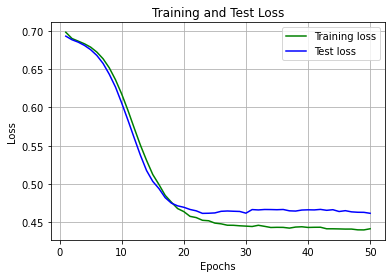

In [17]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Test loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig("../images/loss_plot.png", dpi=300, bbox_inches='tight',facecolor = "w",edgecolor="w")
plt.show()

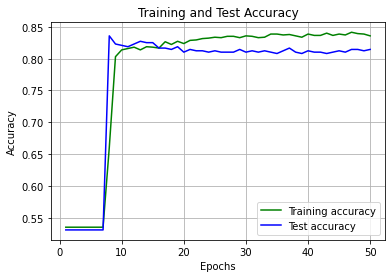

In [18]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Test accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.savefig("../images/accuracy_plot.png", dpi=300, bbox_inches='tight',facecolor = "w",edgecolor="w")
plt.show()

In [19]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,Y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

15/15 - 0s - loss: 0.6495 - accuracy: 0.8380 - 281ms/epoch - 19ms/step
Loss: 0.6494541168212891, Accuracy: 0.8379530906677246


In [20]:
# Summarize the best model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 149)               5811      
                                                                 
 dense_1 (Dense)             (None, 3)                 450       
                                                                 
 dense_2 (Dense)             (None, 9)                 36        
                                                                 
 dense_3 (Dense)             (None, 3)                 30        
                                                                 
 dense_4 (Dense)             (None, 9)                 36        
                                                                 
 dense_5 (Dense)             (None, 1)                 10        
                                                                 
Total params: 6,373
Trainable params: 6,373
Non-trainabl